# Nested Lattice Quantization Demo

This notebook demonstrates sampling from a lattice, adding noise, quantizing, and reconstructing vectors using the Nested Lattice Quantizer.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.lattices.quantizers.nested_lattice_quantizer import NestedLatticeQuantizer
from src.lattices.utils import get_d4, closest_point_Dn, SIG_D4

## Setup D4 Lattice Quantizer

Initialize the D4 lattice quantizer with appropriate parameters.

In [2]:
# D4 lattice parameters
d = 4  # Dimension
G = get_d4()  # Generator matrix for D4 lattice
Q_nn = lambda x: closest_point_Dn(x)  # D4 lattice closest point algorithm
q = 4  # Quantization factor
beta = SIG_D4  # Optimal scaling factor for D4 lattice
alpha = 1.0  # Overload scaling factor
eps = np.zeros(d)  # Epsilon
dither = np.zeros(d)  # Dither

# Create quantizer
quantizer = NestedLatticeQuantizer(G, Q_nn, q, beta, alpha, eps, dither)

## Generate Lattice Samples and Test Quantization

We will:
1. Generate samples from the D4 lattice
2. Add Gaussian noise with different scales
3. Quantize the noisy samples
4. Reconstruct the vectors
5. Compute reconstruction error

In [3]:
# Function to generate lattice points
def generate_lattice_point():
    # Generate random integer coordinates
    coords = np.random.randint(-2, 3, size=d)
    # Transform to lattice point using generator matrix
    return np.dot(G, coords)

# Generate samples and test with different noise scales
noise_scales = [0.1, 0.5, 1.0]
n_samples = 5
results = []

for scale in noise_scales:
    for i in range(n_samples):
        # Generate original lattice point
        original = generate_lattice_point()
        
        # Add Gaussian noise
        noisy = original + np.random.normal(0, scale, size=d)
        
        # Quantize and reconstruct
        enc, T = quantizer.encode(noisy, with_dither=False)
        reconstructed = quantizer.decode(enc, T, with_dither=False)
        
        # Compute error
        error = np.linalg.norm(original - reconstructed)
        
        results.append({
            'Noise Scale': scale,
            'Sample': i + 1,
            'Original': np.round(original, 3),
            'Noisy': np.round(noisy, 3),
            'Reconstructed': np.round(reconstructed, 3),
            'Error': np.round(error, 3)
        })

## Display Results

In [4]:
# Display results in a formatted table
df = pd.DataFrame(results)
print("\nQuantization Results for Different Noise Scales:")
print("=" * 80)
print(df.to_string(index=False))

# Calculate average error for each noise scale
avg_errors = df.groupby('Noise Scale')['Error'].mean()
print("\nAverage Error by Noise Scale:")
print("=" * 40)
print(avg_errors.to_string())


Quantization Results for Different Noise Scales:
 Noise Scale  Sample        Original                           Noisy                    Reconstructed  Error
         0.1       1   [4, 1, -1, 0]   [4.266, 1.063, -1.07, -0.008]      [3.467, 1.733, -1.733, 0.0]  1.166
         0.1       2  [-1, 1, -2, 2]  [-1.012, 1.027, -1.914, 1.901]   [-0.867, 0.867, 1.733, -1.733]  5.283
         0.1       3  [-2, -3, 0, 1] [-1.906, -3.067, -0.046, 0.886]     [-1.733, -3.467, 0.0, 1.733]  0.909
         0.1       4   [3, 1, 1, -1]    [2.867, 1.02, 0.993, -0.963]      [2.6, 0.867, 0.867, -0.867]  0.462
         0.1       5   [4, -2, 0, 2]   [4.117, -2.163, 0.094, 2.065]      [3.467, -1.733, 0.0, 1.733]  0.653
         0.5       1   [3, -1, 1, 1]    [2.292, -1.14, 1.204, 0.972]      [2.6, -0.867, 0.867, 0.867]  0.462
         0.5       2   [3, 1, 1, -1]   [2.913, 1.002, 0.969, -1.469]      [3.467, 1.733, 0.0, -1.733]  1.514
         0.5       3 [-2, -4, 4, -2] [-2.452, -4.007, 3.877, -2.184]  [-1.733,

## Visualize Results

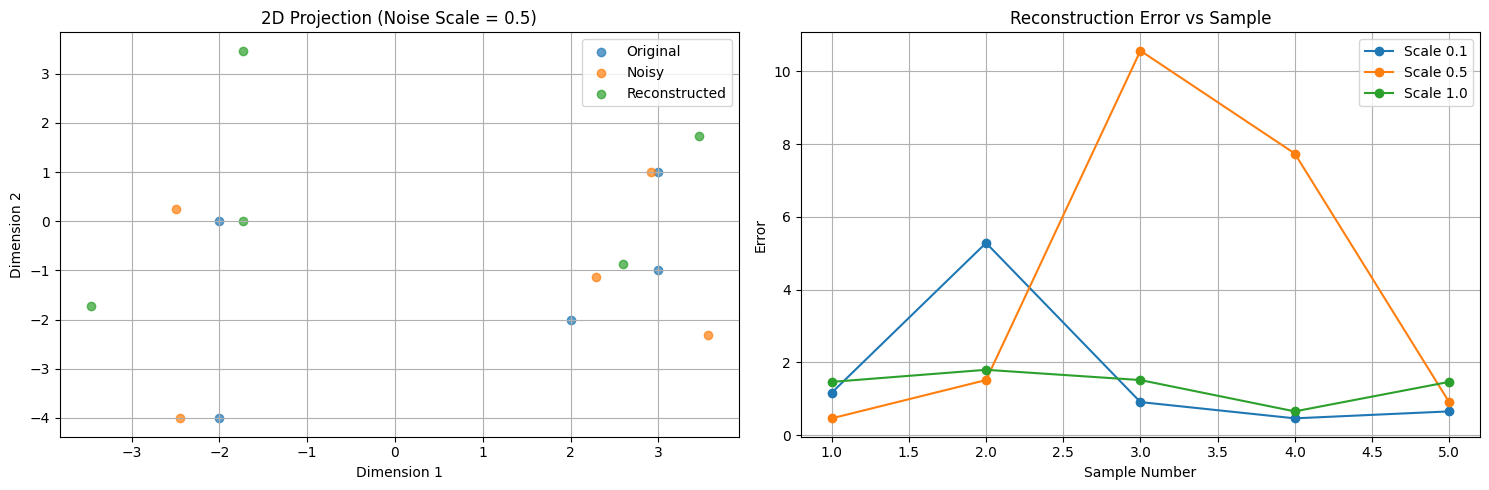

In [5]:
# Visualize original vs reconstructed points for one noise scale
scale_to_plot = 0.5  # middle noise scale
scale_data = df[df['Noise Scale'] == scale_to_plot]

fig = plt.figure(figsize=(15, 5))

# Plot first two dimensions
plt.subplot(121)
plt.scatter([x[0] for x in scale_data['Original']], 
           [x[1] for x in scale_data['Original']], 
           label='Original', alpha=0.7)
plt.scatter([x[0] for x in scale_data['Noisy']], 
           [x[1] for x in scale_data['Noisy']], 
           label='Noisy', alpha=0.7)
plt.scatter([x[0] for x in scale_data['Reconstructed']], 
           [x[1] for x in scale_data['Reconstructed']], 
           label='Reconstructed', alpha=0.7)
plt.title(f'2D Projection (Noise Scale = {scale_to_plot})')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.grid(True)

# Plot error vs sample number for all scales
plt.subplot(122)
for scale in noise_scales:
    scale_data = df[df['Noise Scale'] == scale]
    plt.plot(scale_data['Sample'], scale_data['Error'], 
             'o-', label=f'Scale {scale}')
plt.title('Reconstruction Error vs Sample')
plt.xlabel('Sample Number')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# Test different q values
q_values = [2, 4, 6]
scale = 1  # Fix scale for this analysis
n_samples = 10
q_results = []

# Generate fixed set of test samples
test_samples = [generate_lattice_point() + np.random.normal(0, scale, size=d) for _ in range(n_samples)]

for q_val in q_values:
    # Create quantizer with new q value
    test_quantizer = NestedLatticeQuantizer(
        G=G, 
        Q_nn=Q_nn, 
        q=q_val,
        beta=beta,
        alpha=alpha,
        eps=eps,
        dither=dither
    )
    
    # Test each sample
    for i, sample in enumerate(test_samples):
        enc, T = test_quantizer.encode(sample, with_dither=False)
        reconstructed = test_quantizer.decode(enc, T, with_dither=False)
        error = np.linalg.norm(sample - reconstructed)
        
        q_results.append({
            'q': q_val,
            'Sample': i + 1,
            'Original': np.round(sample, 3),
            'Reconstructed': np.round(reconstructed, 3),
            'Error': np.round(error, 3)
        })

# Create DataFrame for analysis
q_df = pd.DataFrame(q_results)

# Display results
print("\nQuantization Results for Different q values:")
print("=" * 80)
print(q_df.to_string(index=False))

# Calculate average error for each q value
avg_q_errors = q_df.groupby('q')['Error'].mean()
print("\nAverage Error by q value:")
print("=" * 40)
print(avg_q_errors.to_string())


Quantization Results for Different q values:
 q  Sample                        Original                  Reconstructed  Error
 2       1 [-1.526, -0.948, -4.176, 1.522]     [-3.467, 0.0, -3.467, 0.0]  2.736
 2       2  [0.643, -1.247, 1.956, -0.196]      [0.0, 1.733, -1.733, 0.0]  4.790
 2       3   [2.559, -2.733, 2.591, 0.647]      [0.0, 3.467, -3.467, 0.0]  9.061
 2       4  [-2.116, -4.105, 1.515, 0.107]     [-3.467, -3.467, 0.0, 0.0]  2.130
 2       5    [0.669, 0.319, -5.724, 3.88]      [0.0, 0.0, 3.467, -3.467] 11.790
 2       6   [2.263, 0.473, 0.149, -2.583]      [1.733, 0.0, 0.0, -1.733]  1.117
 2       7   [4.581, 0.686, -0.916, 0.481]         [6.933, 0.0, 0.0, 0.0]  2.660
 2       8  [2.902, -1.435, -3.213, 3.454] [3.467, -3.467, 3.467, -3.467]  9.847
 2       9 [-0.009, 5.917, -1.248, -3.062]      [0.0, 6.933, 0.0, -6.933]  4.193
 2      10  [-3.555, 0.856, -4.012, 2.296]     [-3.467, 0.0, -3.467, 0.0]  2.511
 4       1 [-1.526, -0.948, -4.176, 1.522]   [-1.733, 0.0, -3.4

## Analysis of q Parameter Impact

The parameter q affects the quantization in the following ways:
1. Larger q values increase the number of possible quantization levels
2. This can lead to better reconstruction accuracy but requires more bits for encoding
3. However, very large q values might not improve reconstruction significantly due to:
   - The inherent noise in the input signal
   - The scaling factor (beta) becoming the limiting factor
   - The lattice structure's fundamental packing properties

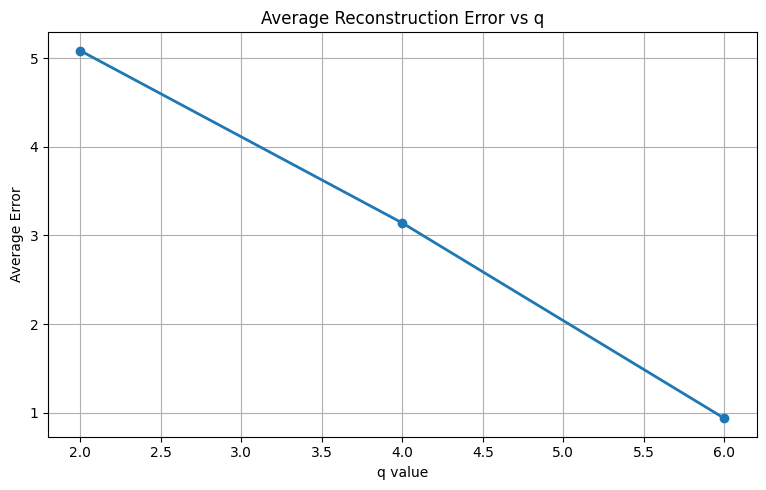

In [7]:
# Visualize the effect of q on reconstruction error
plt.figure(figsize=(15, 5))


# Plot average error by q
plt.subplot(122)
plt.plot(avg_q_errors.index, avg_q_errors.values, 'o-', linewidth=2)
plt.title('Average Reconstruction Error vs q')
plt.xlabel('q value')
plt.ylabel('Average Error')
plt.grid(True)

plt.tight_layout()
plt.show()

## Analysis of q Parameter Impact on Individual Samples

The detailed analysis above shows:
1. How the encoding vector changes with different q values
2. The reconstruction quality for each q value
3. The trade-off between quantization levels and error
4. The overload factor T for different quantization parameters

Key observations:
- Higher q values typically lead to more precise encodings
- The encoding vector length (number of bits) increases with q
- The reconstruction error generally decreases with higher q
- The overload factor T may vary depending on the input vector and q value

In [8]:
# Analyze individual samples with different q values
q_values = [2, 4, 8, 16]
scale = 1.0  # Fixed noise scale
n_samples = 5

# Generate fixed samples for consistent comparison
np.random.seed(42)  # For reproducibility
samples = [generate_lattice_point() + np.random.normal(0, scale, size=d) for _ in range(n_samples)]

# Analyze each sample
for idx, sample in enumerate(samples):
    print(f"\nSample {idx + 1}")
    print("=" * 50)
    print(f"Original vector: {np.round(sample, 3)}")
    print("\nQuantization results for different q values:")
    print("-" * 50)
    
    for q_val in q_values:
        # Create quantizer with current q value
        test_quantizer = NestedLatticeQuantizer(
            G=G, 
            Q_nn=Q_nn, 
            q=q_val,
            beta=beta,
            alpha=alpha,
            eps=eps,
            dither=dither
        )
        
        # Quantize and reconstruct
        enc, T = test_quantizer.encode(sample, with_dither=False)
        reconstructed = test_quantizer.decode(enc, T, with_dither=False)
        error = np.linalg.norm(sample - reconstructed)
        
        print(f"\nq = {q_val}:")
        print(f"  Encoding:      {enc}")
        print(f"  Reconstructed: {np.round(reconstructed, 3)}")
        print(f"  Error:         {np.round(error, 3)}")
        print(f"  Overload T:    {T}")


Sample 1
Original vector: [-0.198 -0.858  1.905 -2.929]

Quantization results for different q values:
--------------------------------------------------

q = 2:
  Encoding:      [0 0 0 1]
  Reconstructed: [ 0.     0.     3.467 -3.467]
  Error:         1.872
  Overload T:    5

q = 4:
  Encoding:      [1 1 1 2]
  Reconstructed: [ 0.    -1.733  1.733 -3.467]
  Error:         1.06
  Overload T:    4

q = 8:
  Encoding:      [1 1 1 3]
  Reconstructed: [ 0.    -0.867  1.733 -2.6  ]
  Error:         0.421
  Overload T:    3

q = 16:
  Encoding:      [3 2 3 7]
  Reconstructed: [-0.433 -0.867  1.733 -3.033]
  Error:         0.31
  Overload T:    2

Sample 2
Original vector: [-1.581 -3.525  1.429 -2.924]

Quantization results for different q values:
--------------------------------------------------

q = 2:
  Encoding:      [1 1 1 1]
  Reconstructed: [ 0.    -3.467  0.    -3.467]
  Error:         2.2
  Overload T:    5

q = 4:
  Encoding:      [2 1 1 2]
  Reconstructed: [-1.733 -3.467  1.733 -

### Understanding the Encoding Process

The encoding process consists of two main components: the inner encoding function and an outer overload handling loop. Here's how it works:

#### Inner Encoding (_encode):
1. **Input Scaling**:
   - Scale input vector x by beta: `x_tag = x/beta`
   - If dithering is enabled, add dither: `x_tag = x_tag + dither`

2. **Lattice Mapping**:
   - Find nearest lattice point: `t = Q_nn(x_tag)`
   - This maps the scaled input to the nearest valid lattice point

3. **Encoding Vector Generation**:
   - Use inverse generator matrix: `y = G_inv * t`
   - Round to integers: `round(y)`
   - Apply modulo q: `enc = y mod q`

4. **Overload Detection**:
   - Scale lattice point: `t_scaled = t/q`
   - Check if scaled point is close to origin: `Q_nn(t_scaled) ≈ 0`
   - If not close to origin, signal overload error

#### Overload Handling (encode):
1. **Initial Attempt**:
   - Try encoding input vector directly
   - Check for overload condition

2. **Iterative Scaling**:
   - If overload occurs:
     * Increment overload counter T
     * Scale input: `x = x/(2^alpha)`
     * Retry encoding
   - Continue until no overload occurs

3. **Final Output**:
   - Return encoding vector (integers in [0, q-1])
   - Return overload factor T

The process ensures that:
- Input vectors are properly mapped to lattice points
- Large values are handled through iterative scaling
- Output encodings are always valid integers in [0, q-1]
- Overload factor T captures the number of scaling iterations needed

This two-stage process allows the quantizer to handle inputs of any magnitude while maintaining the lattice structure's properties.

In [9]:
def manual_encode_inner(x, G, G_inv, beta, q, Q_nn, dither, with_dither=False):
    print("\nInner Encoding Steps (_encode):")
    
    # Step 1: Scale input by beta
    x_tag = x / beta
    print("1. x_tag = x/beta (scaling input):")
    print(x_tag)
    
    # Step 2: Add dither if used
    if with_dither:
        x_tag = x_tag + dither
        print("2. After adding dither:")
        print(x_tag)
    else:
        print("2. Skipping dither (with_dither=False)")
    
    # Step 3: Find nearest lattice point
    t = Q_nn(x_tag)
    print("3. t = Q_nn(x_tag) (nearest lattice point):")
    print(t)
    
    # Step 4: Convert to encoding space using inverse generator matrix
    y = np.dot(G_inv, t)
    print("4. y = G_inv * t (mapping to encoding space):")
    print(y)
    
    # Step 5: Round and apply modulo q
    enc = np.mod(np.round(y), q).astype(int)
    print("5. Final encoding (round(y) mod q):")
    print(enc)
    
    # Step 6: Check for overload
    scaled_t = t / q
    nearest_to_scaled = Q_nn(scaled_t)
    overload_error = not np.allclose(nearest_to_scaled, 0, atol=1e-8)
    print("6. Overload check:")
    print(f"Scaled t: {scaled_t}")
    print(f"Nearest point to scaled t: {nearest_to_scaled}")
    print(f"Overload occurred: {overload_error}")
    
    return enc, overload_error

def manual_encode(x, q, G, beta, alpha, dither, with_dither=False):
    # Get inverse of generator matrix
    G_inv = np.linalg.inv(G)
    
    print("=== Starting Encoding Process ===")
    print("Input vector x:")
    print(x)
    
    # Initialize
    current_x = x.copy()
    t = 0
    
    # First attempt at encoding
    enc, did_overload = manual_encode_inner(current_x, G, G_inv, beta, q, Q_nn, dither, with_dither)
    
    print("\n=== Overload Handling ===")
    print(f"Initial encoding attempt - Overload occurred: {did_overload}")
    
    # Handle overload by repeatedly scaling down input
    while did_overload:
        t += 1
        current_x = current_x / (2 ** alpha)
        print(f"\nOverload iteration {t}:")
        print(f"Scaled input x/(2^{alpha})^{t}:")
        print(current_x)
        
        enc, did_overload = manual_encode_inner(current_x, G, G_inv, beta, q, Q_nn, dither, with_dither)
        print(f"Overload check after iteration {t}: {did_overload}")
    
    print("\n=== Final Results ===")
    print(f"Final T value: {t}")
    print(f"Final encoding: {enc}")
    
    return enc, t

# Let's test with one of our samples
sample_idx = 0
test_vector = samples[sample_idx]

print("=== Testing Manual Encoding ===")
print("Original vector:", test_vector)

# Get encoding using the quantizer
lib_enc, lib_T = test_quantizer.encode(test_vector, with_dither=False)
print("\nLibrary encoding:")
print("Encoding:", lib_enc)
print("T:", lib_T)

# Get encoding using our manual process
manual_enc, manual_T = manual_encode(
    test_vector, q_val, G, beta, alpha, dither, with_dither=False
)
print("\nManual encoding:")
print("Encoding:", manual_enc)
print("T:", manual_T)

# Compare
print("\nComparison:")
print("Encoding difference:", np.linalg.norm(lib_enc - manual_enc))
print("T difference:", lib_T - manual_T)

=== Testing Manual Encoding ===
Original vector: [-0.19780643 -0.85834157  1.905379   -2.9288281 ]

Library encoding:
Encoding: [3 2 3 7]
T: 2
=== Starting Encoding Process ===
Input vector x:
[-0.19780643 -0.85834157  1.905379   -2.9288281 ]

Inner Encoding Steps (_encode):
1. x_tag = x/beta (scaling input):
[ -1.8259349   -7.92328063  17.5883973  -27.03577205]
2. Skipping dither (with_dither=False)
3. t = Q_nn(x_tag) (nearest lattice point):
[ -2.  -8.  17. -27.]
4. y = G_inv * t (mapping to encoding space):
[10.  8. 10. 27.]
5. Final encoding (round(y) mod q):
[10  8 10 11]
6. Overload check:
Scaled t: [-0.125  -0.5     1.0625 -1.6875]
Nearest point to scaled t: [-0. -1.  1. -2.]
Overload occurred: True

=== Overload Handling ===
Initial encoding attempt - Overload occurred: True

Overload iteration 1:
Scaled input x/(2^1.0)^1:
[-0.09890321 -0.42917078  0.9526895  -1.46441405]

Inner Encoding Steps (_encode):
1. x_tag = x/beta (scaling input):
[ -0.91296745  -3.96164032   8.79419865

### Understanding the Decoding Process

In the output above, the "Encoding" vector (y) for each quantization contains integers in [0, q-1]. These numbers represent:

1. **Coordinates in the Lattice Space**: 
   - Each entry is an integer coordinate in the scaled lattice space
   - The vector length matches the lattice dimension (4 for D4)
   - Values are constrained between 0 and q-1

2. **Decoding Process**:
   The decoding process involves several steps:
   ```
   1. x_p = G * y           # Map encoding to lattice space
   2. x_pp = q * Q_nn(x_p/q) # Find nearest point in scaled lattice
   3. diff = x_p - x_pp     # Compute difference from nearest point
   4. result = beta * diff  # Apply beta scaling
   5. final = result * 2^(alpha * T) # Apply overload scaling
   ```
   
   Key components:
   - G: Generator matrix that maps encoding to lattice space
   - Q_nn: Nearest neighbor function in the lattice
   - q: Quantization parameter that determines the lattice scaling
   - beta: Optimal scaling factor for the lattice
   - T: Overload factor for handling larger values
   - alpha: Overload scaling parameter

3. **Why q matters**:
   - Controls the spacing between lattice points
   - Affects the granularity of quantization
   - Larger q means finer quantization but requires more bits
   - Helps balance between precision and compression

The encoding and decoding process ensures efficient quantization while preserving the lattice structure's geometric properties.

In [10]:
def manual_decode(enc, q, G, beta, T, Q_nn, alpha, dither, with_dither=False):
    # Convert encoding to numpy array if it's not already
    enc = np.array(enc)
    
    print("\nDebugging Manual Decoding Steps:")
    print("1. Input encoding vector y:", enc)
    
    # Step 1: Map encoding to lattice space using generator matrix
    x_p = np.dot(G, enc)
    print("\n2. x_p = G * y (mapping to lattice space):")
    print(x_p)
    
    # Step 2: Remove dither if used
    if with_dither:
        x_p = x_p - dither
        print("\n3. After removing dither:")
        print(x_p)
    else:
        print("\n3. Skipping dither removal (with_dither=False)")
    
    # Step 3: Find nearest point in scaled lattice
    # First scale down by q, find nearest lattice point, then scale back up
    x_p_scaled = x_p / q
    print("\n4. x_p/q (scaling down for nearest point search):")
    print(x_p_scaled)
    
    nearest_point = Q_nn(x_p_scaled)
    print("\n5. Nearest lattice point:")
    print(nearest_point)
    
    x_pp = q * nearest_point
    print("\n6. x_pp = q * nearest_point (scaling back up):")
    print(x_pp)
    
    # Step 4: Compute difference and apply beta scaling
    diff = x_p - x_pp
    print("\n7. x_p - x_pp (difference from nearest point):")
    print(diff)
    
    base_result = beta * diff
    print("\n8. After beta scaling:")
    print(base_result)
    
    # Step 5: Apply overload factor
    final_result = base_result * (2 ** (alpha * T))
    print("\n9. Final result after applying overload factor 2^(alpha*T):")
    print(f"alpha: {alpha}, T: {T}, scaling: {2 ** (alpha * T)}")
    print(final_result)
    
    return final_result

# Let's verify this with one of our previous examples
sample_idx = 0  # Let's use the first sample
q_val = 4      # Choose one q value for demonstration

# Create quantizer
test_quantizer = NestedLatticeQuantizer(
    G=G, 
    Q_nn=Q_nn, 
    q=q_val,
    beta=beta,
    alpha=alpha,
    eps=eps,
    dither=dither
)

# Get the encoding
enc, T = test_quantizer.encode(samples[sample_idx], with_dither=False)

print("\n=== Input and Results ===")
print("Original Sample:", np.round(samples[sample_idx], 3))
print("Encoding vector:", enc)
print("Overload factor T:", T)

# Get reconstruction using quantizer's decode method
quantizer_reconstruction = test_quantizer.decode(enc, T, with_dither=False)
print("\nQuantizer reconstruction:", np.round(quantizer_reconstruction, 3))

# Get reconstruction using our manual formula
manual_reconstruction = manual_decode(
    enc, q_val, G, beta, T, Q_nn, alpha, dither, with_dither=False
)
print("\nManual reconstruction:", np.round(manual_reconstruction, 3))

# Compare the two reconstructions
difference = np.linalg.norm(quantizer_reconstruction - manual_reconstruction)
print("\nDifference magnitude:", np.round(difference, 6))
print("Component-wise difference:", np.round(quantizer_reconstruction - manual_reconstruction, 6))


=== Input and Results ===
Original Sample: [-0.198 -0.858  1.905 -2.929]
Encoding vector: [1 1 1 2]
Overload factor T: 4

Quantizer reconstruction: [ 0.    -1.733  1.733 -3.467]

Debugging Manual Decoding Steps:
1. Input encoding vector y: [1 1 1 2]

2. x_p = G * y (mapping to lattice space):
[ 0 -1  1 -2]

3. Skipping dither removal (with_dither=False)

4. x_p/q (scaling down for nearest point search):
[ 0.   -0.25  0.25 -0.5 ]

5. Nearest lattice point:
[-0. -0.  0.  0.]

6. x_pp = q * nearest_point (scaling back up):
[-0. -0.  0.  0.]

7. x_p - x_pp (difference from nearest point):
[ 0. -1.  1. -2.]

8. After beta scaling:
[ 0.         -0.10833159  0.10833159 -0.21666317]

9. Final result after applying overload factor 2^(alpha*T):
alpha: 1.0, T: 4, scaling: 16.0
[ 0.         -1.7333054   1.7333054  -3.46661079]

Manual reconstruction: [ 0.    -1.733  1.733 -3.467]

Difference magnitude: 0.0
Component-wise difference: [0. 0. 0. 0.]
